# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 10

try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter10()

In [1]:
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *
from plots.chapter10 import *

In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, Normalize, Pad

from data_generation.square_sequences import generate_sequences
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 9
from seq2seq import PositionalEncoding, subsequent_mask, EncoderDecoderSelfAttn

# Transform and Roll Out!

## Narrow Attention

### Chunking

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_transf.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/multihead_chunking.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_first_head.png?raw=1)

### Multiheaded Attention

In [3]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

In [4]:
dummy_points = torch.randn(16, 2, 4) # N, L, F
mha = MultiHeadedAttention(n_heads=2, d_model=4, dropout=0.0)
mha.init_keys(dummy_points)
out = mha(dummy_points) # N, L, D
out.shape

torch.Size([16, 2, 4])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_2heads.png?raw=1)

## Stacking Encoders and Decoders

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/stacked_encdec.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/stacked_layers.png?raw=1)

## Wrapping "Sub-Layers"

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sublayer.png?raw=1)

$$
\Large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm(inputs + dropout(sublayer(inputs))}
\\
&\text{outputs}_{\text{norm-first}}=&\text{inputs + dropout(sublayer(norm(inputs)))}
\end{aligned}
$$

## Transformer Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/enc_both.png?raw=1)

$$
\large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0} + \text{ffn}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0}))
\\
\\
&\text{outputs}_{\text{norm-first}}=&\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}+\text{ffn(norm(}\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}))
\end{aligned}
$$

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
         
    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [6]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

In [7]:
enclayer = nn.TransformerEncoderLayer(d_model=6, nhead=3, dim_feedforward=20)
enctransf = nn.TransformerEncoder(enclayer, num_layers=1, norm=nn.LayerNorm)

## Transformer Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/dec_both.png?raw=1)

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)
                
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Masked Multi-head Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, target_mask)
        # Add
        att1 = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att1 = self.norm2(att1)
        # Multi-head Attention
        encoder_states = self.cross_attn_heads(norm_att1, source_mask)
        # Add
        att2 = att1 + self.drop2(encoder_states)
        
        # Sublayer #2
        # Norm
        norm_att2 = self.norm3(att2)
        # Feed Forward
        out = self.ffn(norm_att2)
        # Add
        out = att2 + self.drop3(out)
        return out

In [9]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])
        
    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

In [10]:
declayer = nn.TransformerDecoderLayer(d_model=6, nhead=3, dim_feedforward=20)
dectransf = nn.TransformerDecoder(declayer, num_layers=1, norm=nn.LayerNorm)

## Layer Normalization

In [11]:
d_model = 4
seq_len = 2
n_points = 3

torch.manual_seed(34)
data = torch.randn(n_points, seq_len, d_model)
pe = PositionalEncoding(seq_len, d_model)
inputs = pe(data)
inputs

tensor([[[-3.8049,  1.9899, -1.7325,  2.1359],
         [ 1.7854,  0.8155,  0.1116, -1.7420]],

        [[-2.4273,  1.3559,  2.8615,  2.0084],
         [-1.0353, -1.2766, -2.2082, -0.6952]],

        [[-0.8044,  1.9707,  3.3704,  2.0587],
         [ 4.2256,  6.9575,  1.4770,  2.0762]]])

$$
\Large
\overline{X}_{n,l} = \frac{1}{D}\sum_{d=1}^Dx_{n,l,d}
$$

In [12]:
inputs_mean = inputs.mean(axis=2).unsqueeze(2)
inputs_mean

tensor([[[-0.3529],
         [ 0.2426]],

        [[ 0.9496],
         [-1.3038]],

        [[ 1.6489],
         [ 3.6841]]])

$$
\Large
\sigma_{n,l}(X) = \sqrt{\frac{1}{D}\sum_{d=1}^D(x_{n,l,d}-\overline{X}_{n,l})^2}
$$

In [13]:
inputs_var = inputs.var(axis=2, unbiased=False).unsqueeze(2)
inputs_var

tensor([[[6.3756],
         [1.6661]],

        [[4.0862],
         [0.3153]],

        [[2.3135],
         [4.6163]]])

$$
\Large
\text{standardized}\ x_{n,l,d}=\frac{x_{n,l,d}-\overline{X}_{n,l}}{\sigma_{n,l}(X) + \epsilon}
$$

In [14]:
(inputs - inputs_mean)/torch.sqrt(inputs_var+1e-5)

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]])

In [15]:
layer_norm = nn.LayerNorm(d_model)
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

In [16]:
layer_norm = nn.LayerNorm(d_model)
normalized = layer_norm(inputs)

normalized[0][0].mean(), normalized[0][0].std(unbiased=False)

(tensor(-1.4901e-08, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward0>))

In [17]:
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

$$
\Large
\text{layer normed}\ x_{n,l,d} = b_d + w_d\ \text{standardized}\ x_{n,l,d}
$$

$$
\Large
\text{layer normed}\ x_{n,l,d} = \text{standardized}\ x_{n,l,d}\ \gamma_d + \beta_d
$$

### Batch vs Layer

In [18]:
torch.manual_seed(23)
dummy_points = torch.randn(4, 1, 256)
dummy_pe = PositionalEncoding(1, 256)
dummy_enc = dummy_pe(dummy_points)
dummy_enc

tensor([[[-14.4193,  10.0495,  -7.8116,  ..., -15.4844, -18.0732,  -3.9566]],

        [[  2.6628,  -3.5462, -23.6461,  ...,  -0.9403, -18.4375, -37.4197]],

        [[-24.6397,  -1.9127, -16.4244,  ..., -17.3708, -26.0550, -14.0706]],

        [[ 13.7988,  21.4612,  10.4125,  ...,  -3.2333, -17.0188,   3.9237]]])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/layer_vs_batch_norm.png?raw=1)

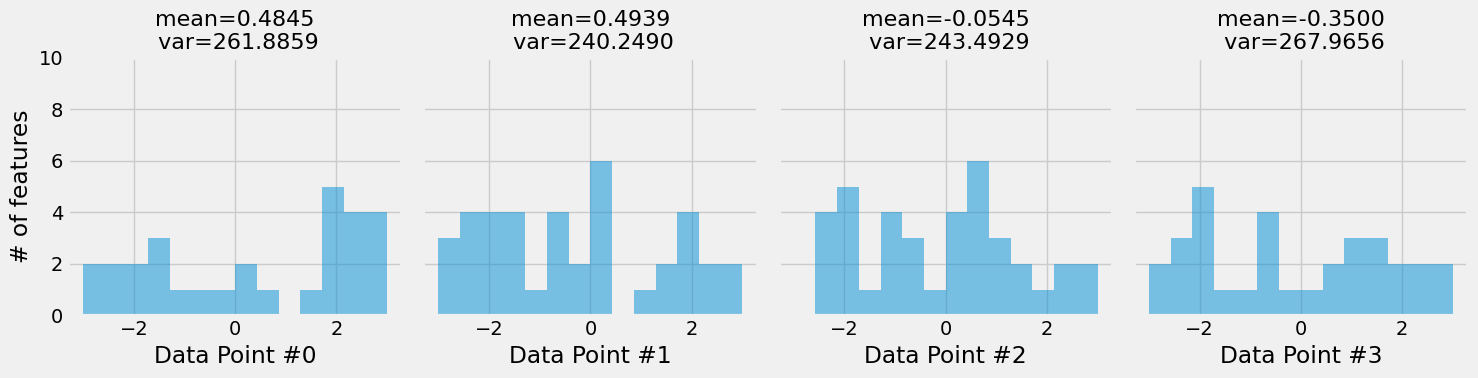

In [19]:
fig = hist_encoding(dummy_enc)

In [20]:
layer_normalizer = nn.LayerNorm(256)
dummy_normed = layer_normalizer(dummy_enc)
dummy_normed

tensor([[[-0.9210,  0.5911, -0.5127,  ..., -0.9868, -1.1467, -0.2744]],

        [[ 0.1399, -0.2607, -1.5574,  ..., -0.0925, -1.2214, -2.4460]],

        [[-1.5755, -0.1191, -1.0491,  ..., -1.1097, -1.6662, -0.8982]],

        [[ 0.8643,  1.3324,  0.6575,  ..., -0.1761, -1.0183,  0.2611]]],
       grad_fn=<NativeLayerNormBackward0>)

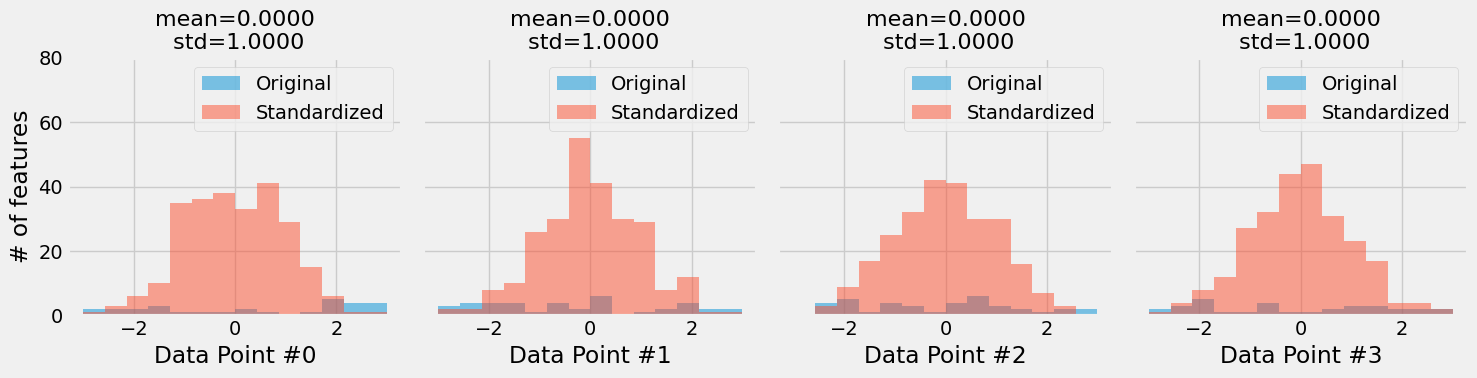

In [21]:
fig = hist_layer_normed(dummy_enc, dummy_normed)

### Our Seq2Seq Problem

In [22]:
pe = PositionalEncoding(max_len=2, d_model=2)

source_seq = torch.tensor([[[ 1.0349,  0.9661], [ 0.8055, -0.9169]]])
source_seq_enc = pe(source_seq)
source_seq_enc

tensor([[[ 1.4636,  2.3663],
         [ 1.9806, -0.7564]]])

In [23]:
norm = nn.LayerNorm(2)
norm(source_seq_enc)

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

### Projections or Embeddings

In [24]:
torch.manual_seed(11)
proj_dim = 6
linear_proj = nn.Linear(2, proj_dim)
pe = PositionalEncoding(2, proj_dim)

source_seq_proj = linear_proj(source_seq)
source_seq_proj_enc = pe(source_seq_proj)
source_seq_proj_enc

tensor([[[-2.0934,  1.5040,  1.8742,  0.0628,  0.3034,  2.0190],
         [-0.8853,  2.8213,  0.5911,  2.4193, -2.5230,  0.3599]]],
       grad_fn=<AddBackward0>)

In [25]:
norm = nn.LayerNorm(proj_dim)
norm(source_seq_proj_enc)

tensor([[[-1.9061,  0.6287,  0.8896, -0.3868, -0.2172,  0.9917],
         [-0.7362,  1.2864,  0.0694,  1.0670, -1.6299, -0.0568]]],
       grad_fn=<NativeLayerNormBackward0>)

## The Transformer

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/full_transformer.png?raw=1)

In [26]:
class EncoderDecoderTransf(EncoderDecoderSelfAttn):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__(encoder, decoder, input_len, target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)
            
    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)    
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

In [27]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super(EncoderDecoderSelfAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequence_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Data Preparation

In [28]:
# Generating training data
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
# Generating test data
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
# Datasets and data loaders
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

/var/folders/74/v7qc979j2z7d9j_wsymkmkrc0000gn/T/ipykernel_10779/572022234.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  full_train = torch.as_tensor(points).float()


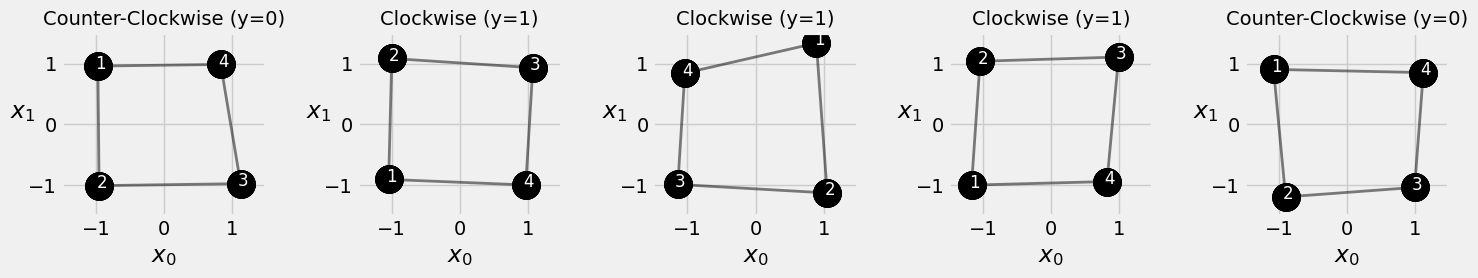

In [29]:
fig = plot_data(points, directions, n_rows=1)

### Model Configuration & Training

In [30]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [31]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [32]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

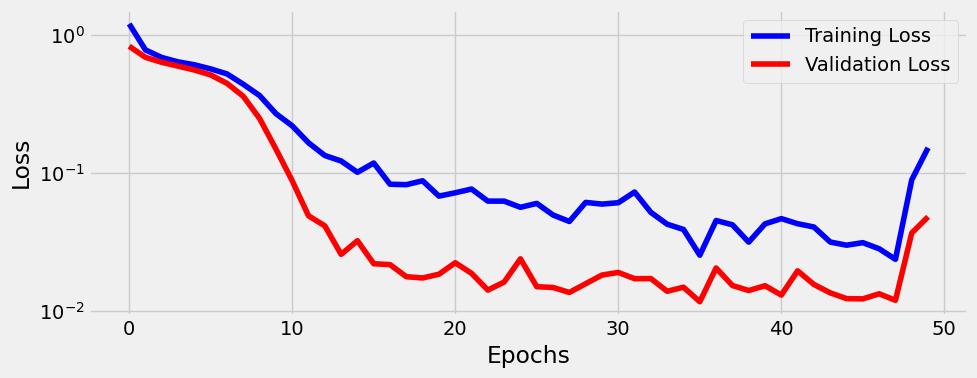

In [33]:
fig = sbs_seq_transf.plot_losses()

In [34]:
torch.manual_seed(11)
x, y = next(iter(train_loader))
device = sbs_seq_transf.device
# Training
model_transf.train()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.3212, device='mps:0', grad_fn=<MseLossBackward0>)

In [35]:
# Validation
model_transf.eval()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0433, device='mps:0')

### Visualizing Predictions

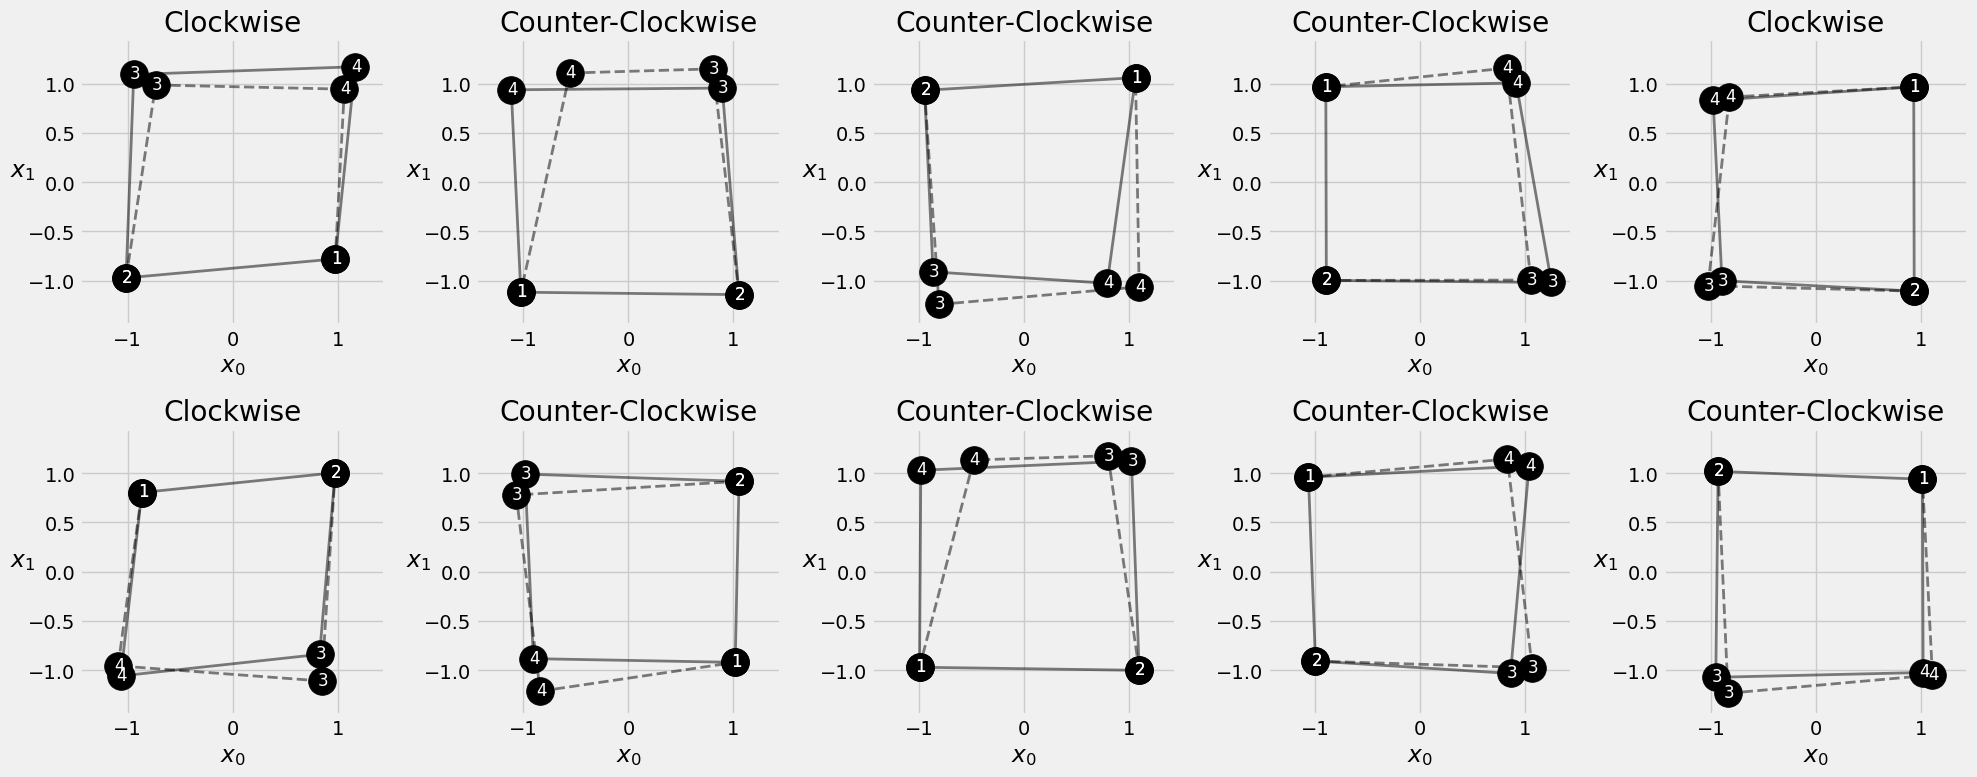

In [36]:
fig = sequence_pred(sbs_seq_transf, full_test, test_directions)

## The PyTorch Transformer

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sublayer.png?raw=1)

In [37]:
def encode_decode(self, source, target, source_mask=None, target_mask=None):
    # Projections
    # PyTorch Transformer expects L, N, F
    src = self.preprocess(source).permute(1, 0, 2)
    tgt = self.preprocess(target).permute(1, 0, 2)

    out = self.transf(src, tgt, 
                      src_key_padding_mask=source_mask, 
                      tgt_mask=target_mask)

    # Linear
    # Back to N, L, D
    out = out.permute(1, 0, 2)
    out = self.linear(out) # N, L, F
    return out

In [38]:
class TransformerModel(nn.Module):
    def __init__(self, transformer, input_len, target_len, n_features):
        super().__init__()
        self.transf = transformer
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.transf.generate_square_subsequent_mask(self.target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, self.transf.d_model)
        self.linear = nn.Linear(self.transf.d_model, n_features)
        
        max_len = max(self.input_len, self.target_len)
        self.pe = PositionalEncoding(max_len, self.transf.d_model)
        self.norm = nn.LayerNorm(self.transf.d_model)
                
    def preprocess(self, seq):
        seq_proj = self.proj(seq)
        seq_enc = self.pe(seq_proj)
        return self.norm(seq_enc)
    
    def encode_decode(self, source, target, source_mask=None, target_mask=None):
        # Projections
        # PyTorch Transformer expects L, N, F
        src = self.preprocess(source).permute(1, 0, 2)
        tgt = self.preprocess(target).permute(1, 0, 2)

        out = self.transf(src, tgt, 
                          src_key_padding_mask=source_mask, 
                          tgt_mask=target_mask)

        # Linear
        # Back to N, L, D
        out = out.permute(1, 0, 2)
        out = self.linear(out) # N, L, F
        return out
        
    def predict(self, source_seq, source_mask=None):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.encode_decode(source_seq, inputs, 
                                     source_mask=source_mask,
                                     target_mask=self.trg_masks[:i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = out[:, 1:, :]
        return outputs
        
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X)
        source_seq = X[:, :self.input_len, :]
        
        if self.training:            
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.encode_decode(source_seq, shifted_target_seq, 
                                         source_mask=source_mask, 
                                         target_mask=self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Model Configuration & Training

In [39]:
torch.manual_seed(42)
transformer = nn.Transformer(d_model=6, nhead=3, 
                             num_encoder_layers=1, num_decoder_layers=1,
                             dim_feedforward=20, dropout=0.1)
model_transformer = TransformerModel(transformer, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)

In [40]:
for p in model_transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [41]:
sbs_seq_transformer = StepByStep(model_transformer, loss, optimizer)
sbs_seq_transformer.set_loaders(train_loader, test_loader)
sbs_seq_transformer.train(50)

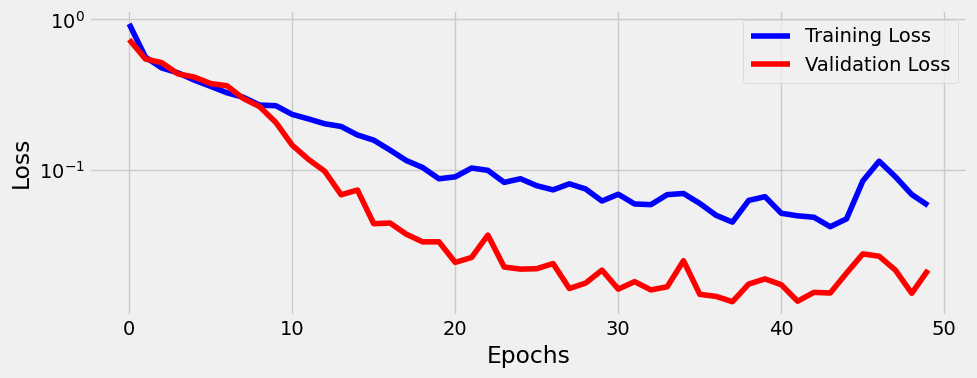

In [42]:
fig = sbs_seq_transformer.plot_losses()

### Visualizing Predictions

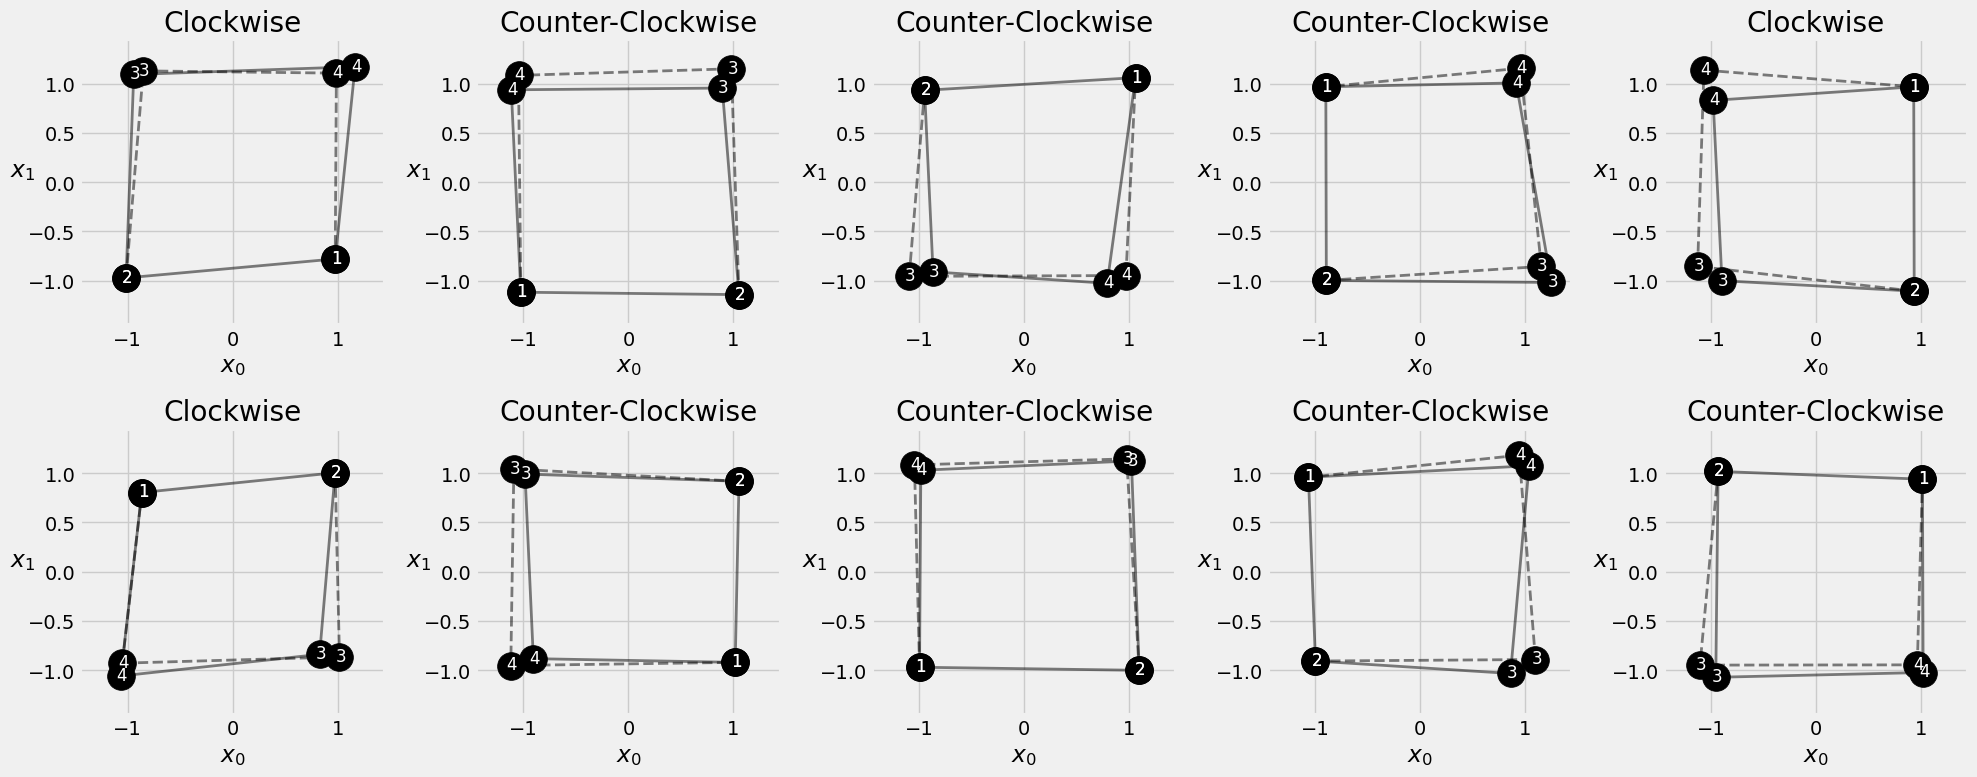

In [43]:
fig = sequence_pred(sbs_seq_transformer, full_test, test_directions)

## Vision Transformer

### Data Generation & Preparation

In [44]:
images, labels = generate_dataset(img_size=12, n_images=1000, binary=False, seed=17)

In [45]:
img = torch.as_tensor(images[2]).unsqueeze(0).float()/255.

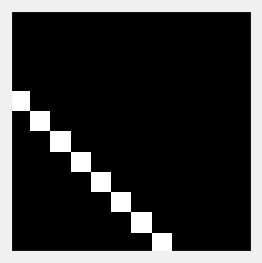

In [46]:
fig = plot_images(img, title=False)

In [47]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
                
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)
            
        return x, self.y[index]
            
    def __len__(self):
        return len(self.x)

# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Patches

#### Rearranging

In [48]:
# Adapted from https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837 
def extract_image_patches(x, kernel_size, stride=1):
    # Extract patches
    patches = x.unfold(2, kernel_size, stride)
    patches = patches.unfold(3, kernel_size, stride)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    
    return patches.view(x.shape[0], patches.shape[1], patches.shape[2], -1)

In [49]:
kernel_size = 4
patches = extract_image_patches(img, kernel_size, stride=kernel_size)
patches.shape

torch.Size([1, 3, 3, 16])

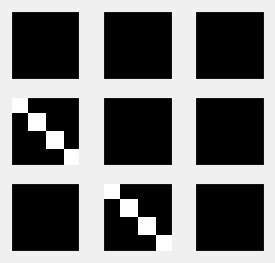

In [50]:
fig = plot_patches(patches, kernel_size=kernel_size)

In [51]:
seq_patches = patches.view(-1, patches.size(-1))

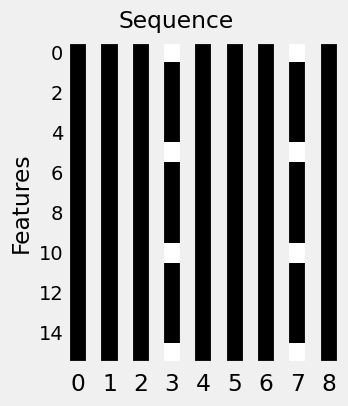

In [52]:
fig = plot_seq_patches(seq_patches)

In [53]:
# Adapted from https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py
# !pip install einops
# from einops import rearrange
# patches = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
#                     p1 = kernel_size, p2 = kernel_size)
# patches.shape

#### Embeddings

In [54]:
# Adapted from https://amaarora.github.io/2021/01/18/ViT.html
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, dilation=1):
        super().__init__()        
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [55]:
torch.manual_seed(13)
patch_embed = PatchEmbed(img.size(-1), kernel_size, 1, kernel_size**2)
embedded = patch_embed(img)
embedded.shape

torch.Size([1, 9, 16])

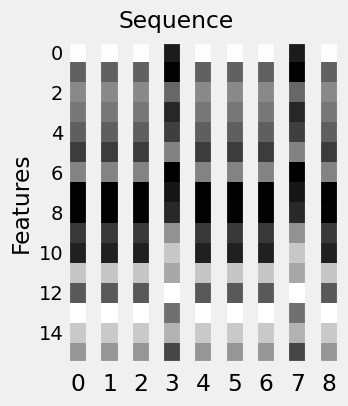

In [56]:
fig = plot_seq_patches(embedded[0])

### Special Classifier Token

In [57]:
imgs = torch.as_tensor(images[2:4]).float()/255.

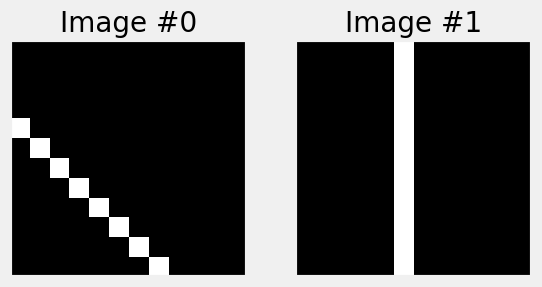

In [58]:
fig = plot_images(imgs)

In [59]:
embeddeds = patch_embed(imgs)

/Users/norman/Data Science/PyTorchStepByStep/plots/chapter10.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i+1].set_yticklabels([label], rotation=0)


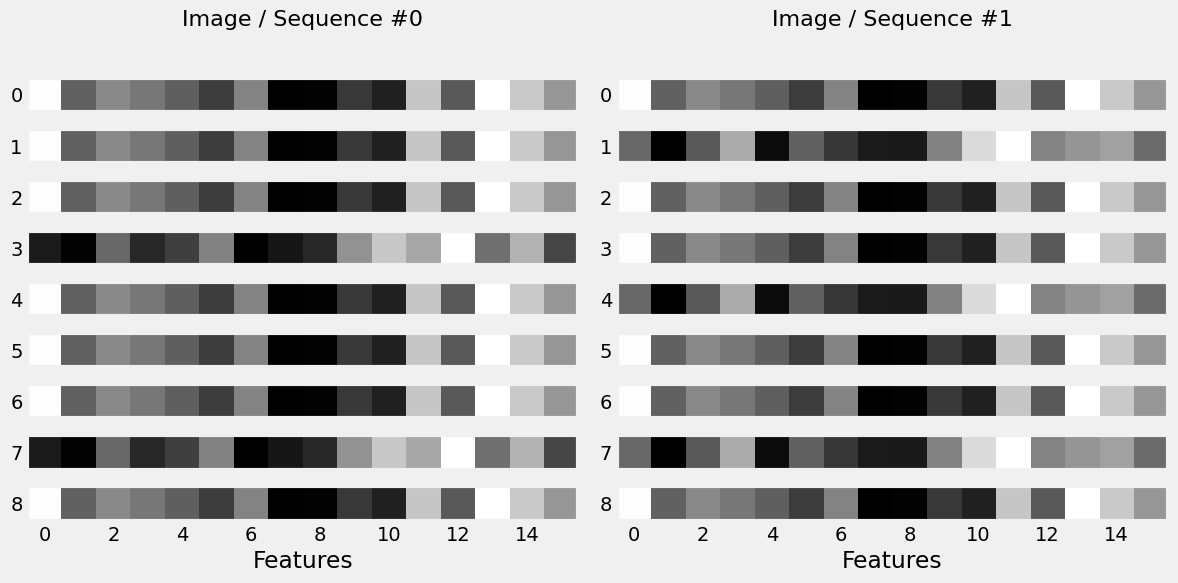

In [60]:
fig = plot_seq_patches_transp(embeddeds, add_cls=False, title='Image / Sequence')

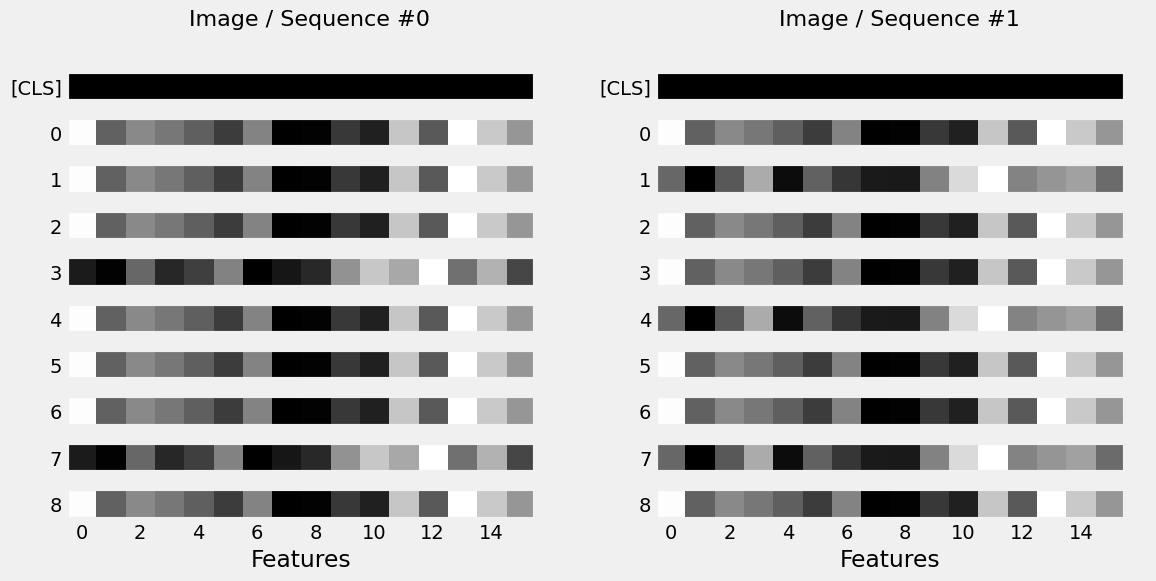

In [61]:
fig = plot_seq_patches_transp(embeddeds, add_cls=True, title='Image / Sequence')

In [62]:
cls_token = nn.Parameter(torch.zeros(1, 1, 16))
cls_token

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       requires_grad=True)

In [63]:
images, labels = next(iter(train_loader))
images.shape # N, C, H, W

torch.Size([16, 1, 12, 12])

In [64]:
embed = patch_embed(images)
embed.shape # N, L, D

torch.Size([16, 9, 16])

In [65]:
cls_tokens = cls_token.expand(embed.size(0), -1, -1)
embed_cls = torch.cat((cls_tokens, embed), dim=1)
embed_cls.shape # N, L+1, D

torch.Size([16, 10, 16])

### The Model

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/vit_model.png?raw=1)

In [66]:
class ViT(nn.Module):
    def __init__(self, encoder, img_size, in_channels, patch_size, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(encoder.d_model, n_outputs)

        self.embed = PatchEmbed(img_size, patch_size, in_channels, encoder.d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, encoder.d_model))
        
    def preprocess(self, X):
        # Patch embeddings
        # N, L, F -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src
    
    def encode(self, source):
        # Encoder generates "hidden states"
        states = self.encoder(source)
        # Gets state from first token: CLS
        cls_state = states[:, 0]  # N, 1, D
        return cls_state
        
    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src)
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

### Model Configuration & Training

In [67]:
torch.manual_seed(17)
layer = EncoderLayer(n_heads=2, d_model=16, ff_units=20)
encoder = EncoderTransf(layer, n_layers=1)
model_vit = ViT(encoder, img_size=12, in_channels=1, patch_size=4, n_outputs=3)
multi_loss_fn = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-3)

In [68]:
sbs_vit = StepByStep(model_vit, multi_loss_fn, optimizer_vit)
sbs_vit.set_loaders(train_loader, val_loader)
sbs_vit.train(20)

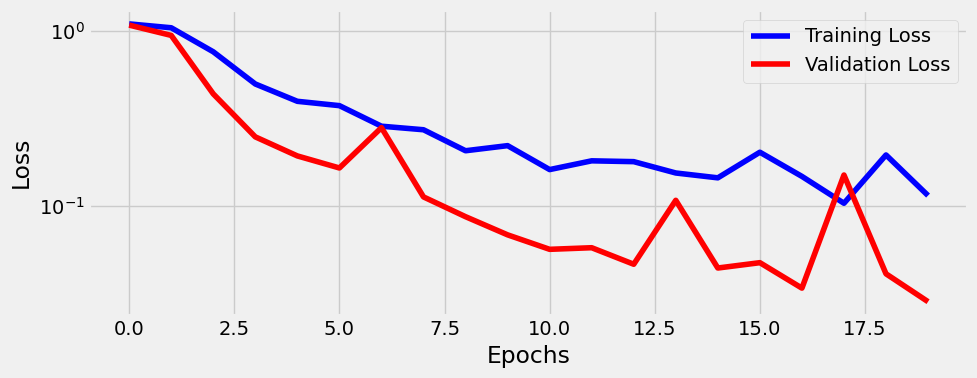

In [69]:
fig = sbs_vit.plot_losses()

In [70]:
model_vit.cls_token

Parameter containing:
tensor([[[ 0.0946, -0.0534,  0.0241, -0.0588,  0.0679, -0.0812,  0.0849,
          -0.0525,  0.0704, -0.0564,  0.0577, -0.0370,  0.0854, -0.0601,
           0.0866, -0.0607]]], device='mps:0', requires_grad=True)

In [71]:
StepByStep.loader_apply(sbs_vit.val_loader, sbs_vit.correct)

tensor([[76, 76],
        [65, 65],
        [58, 59]])

## Putting It All Together

### Data Preparation

In [72]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### Model Assembly

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/full_transformer_and_class.png?raw=1)

#### 1. Encoder-Decoder

In [73]:
class EncoderDecoderTransf(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)
            
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)    
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs
    
    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

#### 2. Encoder

In [74]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])
    
    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

#### 3. Decoder

In [75]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])
        
    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

#### 4. Positional Encoding

In [76]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        slope = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * slope) # even dimensions
        pe[:, 1::2] = torch.cos(position * slope) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

#### 5. Encoder "Layer"

In [77]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(2)])
         
    def forward(self, query, mask=None):
        # SubLayer 0 - Self-Attention
        att = self.sublayers[0](query,
                                sublayer=self.self_attn_heads, 
                                is_self_attn=True,
                                mask=mask)
        # SubLayer 1 - FFN
        out = self.sublayers[1](att, sublayer=self.ffn)
        return out

#### 6. Decoder "Layer"

In [78]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, 
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(3)])
                
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        # SubLayer 0 - Masked Self-Attention
        att1 = self.sublayers[0](query, 
                                 sublayer=self.self_attn_heads, 
                                 is_self_attn=True, 
                                 mask=target_mask)
        # SubLayer 1 - Cross-Attention
        att2 = self.sublayers[1](att1, 
                                 sublayer=self.cross_attn_heads, 
                                 mask=source_mask)
        # SubLayer 2 - FFN
        out = self.sublayers[2](att2, sublayer=self.ffn)
        return out

#### 7. "SubLayer" Wrapper

In [79]:
class SubLayerWrapper(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x, sublayer, is_self_attn=False, **kwargs):
        norm_x = self.norm(x)
        if is_self_attn:
            sublayer.init_keys(norm_x)
        out = x + self.drop(sublayer(norm_x, **kwargs))
        return out

In [80]:
# Before
def forward(self, query, mask=None):
    # query and mask go in
    norm_query = self.norm1(query)
    self.self_attn_heads.init_keys(norm_query)
    # the sublayer is the self-attention
    states = self.self_attn_heads(norm_query, mask)
    att = query + self.drop1(states)
    # att comes out
    ...
    
# After
def forward(self, query, mask=None):
    # query and mask go in
    # the sublayer is the self-attention
    # norm, drop, and residual are inside the wrapper
    att = self.sublayers[0](query,
                            sublayer=self.self_attn_heads, 
                            is_self_attn=True,
                            mask=mask)
    # att comes out
    ...

#### 8. Multi-Headed Attention

In [81]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k) 
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)  
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))
        
    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query, 
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        
        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context        
                                
    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out
        
    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)        
        # N, L, d_model
        out = self.output_function(context)
        return out

### Model Configuration & Training

In [82]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [83]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [84]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

In [85]:
sbs_seq_transf.losses[-1], sbs_seq_transf.val_losses[-1]

(0.15282990271225572, 0.04826410673558712)